In [ ]:
!pip install git+https://github.com/huggingface/diffusers transformers accelerate datasets

In [ ]:
!pip list | egrep "torch|diffusers|transformers|accelerate" 

```
accelerate                        1.7.0
diffusers                         0.34.0.dev0
torch                             2.4.1+cu124
torchaudio                        2.4.1+cu124
torchvision                       0.19.1+cu124
transformers                      4.52.4
```

In [ ]:
from huggingface_hub import login

hf_token = "XXX"
login(token=hf_token)

In [19]:
# source: https://github.com/yiyixuxu/cosmos-guardrail/blob/bcdd61ba485c6f1aaee3661bc9022fdc1183fe8a/src/cosmos_guardrail/cosmos_guardrail.py#L691

from typing import Union

import numpy as np
import torch

from diffusers.configuration_utils import ConfigMixin
from diffusers.models.modeling_utils import ModelMixin

class DummyCosmosSafetyChecker(ModelMixin, ConfigMixin):
    def __init__(self) -> None:
        super().__init__()

        self._dtype = torch.float32

    def check_text_safety(self, prompt: str) -> bool:
        return True

    def check_video_safety(self, frames: np.ndarray) -> np.ndarray:
        return frames

    def to(self, device: Union[str, torch.device] = None, dtype: torch.dtype = None) -> None:
        self._dtype = dtype

    @property
    def device(self) -> torch.device:
        return torch.device("cuda")

    @property
    def dtype(self) -> torch.dtype:
        return self._dtype

# Text-to-Image
runs on an 24GB VRAM GPU

In [ ]:
import torch
from diffusers import Cosmos2TextToImagePipeline

model_id = "nvidia/Cosmos-Predict2-2B-Video2World"

pipe = Cosmos2TextToImagePipeline.from_pretrained(
    model_id, 
    torch_dtype=torch.bfloat16,
    safety_checker=DummyCosmosSafetyChecker(),
).to("cuda")

In [ ]:
prompt = "A close-up shot captures a vibrant yellow scrubber vigorously working on a grimy plate, its bristles moving in circular motions to lift stubborn grease and food residue. The dish, once covered in remnants of a hearty meal, gradually reveals its original glossy surface. Suds form and bubble around the scrubber, creating a satisfying visual of cleanliness in progress. The sound of scrubbing fills the air, accompanied by the gentle clinking of the dish against the sink. As the scrubber continues its task, the dish transforms, gleaming under the bright kitchen lights, symbolizing the triumph of cleanliness over mess."
negative_prompt = "The video captures a series of frames showing ugly scenes, static with no motion, motion blur, over-saturation, shaky footage, low resolution, grainy texture, pixelated images, poorly lit areas, underexposed and overexposed scenes, poor color balance, washed out colors, choppy sequences, jerky movements, low frame rate, artifacting, color banding, unnatural transitions, outdated special effects, fake elements, unconvincing visuals, poorly edited content, jump cuts, visual noise, and flickering. Overall, the video is of poor quality."

output = pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps = 35,
    generator=torch.Generator().manual_seed(42)
).images[0]

output

## Explore number of steps

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import platform

def make_grid(images, rows=1, cols=None):
    if cols is None: cols = len(images)
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def pil_add_text(image, text, position=None, font_size=None, font_color=(255, 255, 255), 
                       font_path=None, stroke_width=1, stroke_fill=(0, 0, 0)):
    if font_path is None: 
        if platform.system() == "Darwin":
            font_path = "Times.ttc"
        else:
            font_path = "DejaVuSans.ttf"
    w, h = image.size
    if position is None: position = (w//10, h//10)
    if font_size is None: font_size = round(h*0.1)
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)
    font = ImageFont.truetype(font_path, font_size)

    draw.text(
        position,
        text,
        font=font,
        fill=font_color,
        stroke_width=stroke_width,
        stroke_fill=stroke_fill
    )
    
    return img_copy


In [ ]:
from tqdm import tqdm 

images = [
    pil_add_text(
        pipe(
            prompt=prompt, 
            negative_prompt=negative_prompt,
            num_inference_steps = steps,
            generator=torch.Generator().manual_seed(42)
        ).images[0],
        f"{steps} steps",
        position = (10,100),
        stroke_width = 5,
    )
    for steps in [5, 10, 20, 35, 50]
]

In [ ]:
make_grid(images)

## Prompt explore

In [ ]:
from datasets import load_dataset
import random

def load_prompts(n=10, seed=42):
    dataset = load_dataset("k-mktr/improved-flux-prompts-photoreal-portrait")
    
    random.seed(seed)
    random_indices = random.sample(range(len(dataset['train'])), n)
    random_prompts = [dataset['train'][i]['prompt'] for i in random_indices]

    return random_prompts

prompts = load_prompts()

In [ ]:
from tqdm import tqdm 

images = [
    pil_add_text(
        pipe(
            prompt=prompt, 
            negative_prompt=negative_prompt,
            num_inference_steps = 35,
            generator=torch.Generator().manual_seed(42)
        ).images[0],
        str(i),
        position = (10, 10),
        stroke_width = 5,
    )
    for i,prompt in enumerate(tqdm(prompts))
]

In [ ]:
make_grid(images, rows=2, cols=5).save("gallery.png")

# Image-to-Video¶

```
accelerate                1.7.0
diffusers                 0.34.0.dev0
pytorch-triton            3.3.0+git96316ce5
torch                     2.8.0.dev20250319+cu128
torchaudio                2.6.0.dev20250319+cu128
torchvision               0.22.0.dev20250319+cu128
transformers              4.52.4
```

In [ ]:
!pip install opencv-python imageio imageio-ffmpeg

In [20]:
import torch
from diffusers import Cosmos2VideoToWorldPipeline
from diffusers.utils import export_to_video, load_image

# Available checkpoints: nvidia/Cosmos-Predict2-2B-Video2World, nvidia/Cosmos-Predict2-14B-Video2World
model_id = "nvidia/Cosmos-Predict2-2B-Video2World"
pipe = Cosmos2VideoToWorldPipeline.from_pretrained(
    model_id, 
    torch_dtype=torch.bfloat16,
    safety_checker=DummyCosmosSafetyChecker(),
).to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The config attributes {'final_sigmas_type': 'sigma_min', 'sigma_data': 1.0, 'sigma_max': 80.0, 'sigma_min': 0.002} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
Expected types for safety_checker: (<class 'diffusers.pipelines.cosmos.pipeline_cosmos2_video2world.CosmosSafetyChecker'>,), got <class '__main__.DummyCosmosSafetyChecker'>.


In [ ]:
prompt = "A close-up shot captures a vibrant yellow scrubber vigorously working on a grimy plate, its bristles moving in circular motions to lift stubborn grease and food residue. The dish, once covered in remnants of a hearty meal, gradually reveals its original glossy surface. Suds form and bubble around the scrubber, creating a satisfying visual of cleanliness in progress. The sound of scrubbing fills the air, accompanied by the gentle clinking of the dish against the sink. As the scrubber continues its task, the dish transforms, gleaming under the bright kitchen lights, symbolizing the triumph of cleanliness over mess."
negative_prompt = "The video captures a series of frames showing ugly scenes, static with no motion, motion blur, over-saturation, shaky footage, low resolution, grainy texture, pixelated images, poorly lit areas, underexposed and overexposed scenes, poor color balance, washed out colors, choppy sequences, jerky movements, low frame rate, artifacting, color banding, unnatural transitions, outdated special effects, fake elements, unconvincing visuals, poorly edited content, jump cuts, visual noise, and flickering. Overall, the video is of poor quality."
image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/yellow-scrubber.png"
)

video = pipe(
    image=image, prompt=prompt, negative_prompt=negative_prompt, generator=torch.Generator().manual_seed(1),
).frames[0]
export_to_video(video, "output.mp4", fps=16)

## More

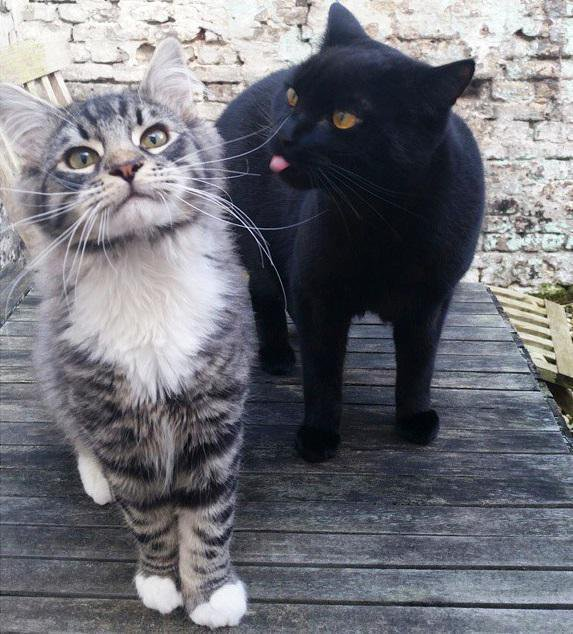

In [21]:
from diffusers.utils import load_image

image = load_image("https://pbs.twimg.com/media/Cobgkh1XEAA7ttg?format=jpg&name=small")
image

In [ ]:
prompt = "In a rustic backyard, two cats are on a wooden deck. The gray tabby sits attentively, gazing upwards, while a black cat playfully approaches, sticking out its tongue. They interact, exploring the deck together, their tails twitching with excitement. As they leap and chase each other, sunlight filters through the trees, casting a warm glow on the scene. The video ends with both cats sitting side by side, content and curious."
negative_prompt = "The video captures a series of frames showing ugly scenes, static with no motion, motion blur, over-saturation, shaky footage, low resolution, grainy texture, pixelated images, poorly lit areas, underexposed and overexposed scenes, poor color balance, washed out colors, choppy sequences, jerky movements, low frame rate, artifacting, color banding, unnatural transitions, outdated special effects, fake elements, unconvincing visuals, poorly edited content, jump cuts, visual noise, and flickering. Overall, the video is of poor quality."

video = pipe(
    image=image, prompt=prompt, negative_prompt=negative_prompt, generator=torch.Generator().manual_seed(1),
).frames[0]
export_to_video(video, "output_cats.mp4", fps=16)

  0%|          | 0/35 [00:00<?, ?it/s]